In [1]:
import csv
import pandas as pd
import matplotlib.pyplot as plt
import statistics
import math
import numpy as np
from scipy.stats import linregress
from scipy import stats
import datetime   
from pandas import Series
from statsmodels.tsa.stattools import adfuller
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from sklearn.metrics import mean_squared_error
from scipy.io import wavfile

In [70]:
mypath='C:/Users/sara/Documents/5anno/TESI/tracciati/ConversioneExcel/A E12.06.18'    
df_spo2 = pd.read_csv( mypath+'/SpO2_PDS.csv', names=['time', 'spO2'])
df_activity = pd.read_csv( mypath+'/Activity_PDS.csv', names=['time', 'activity'])
spo2_array=df_spo2['spO2']
time_array=df_spo2['time']
activity_array=df_activity['activity']
time_activity_array=df_activity['time']

In [483]:
# lettura del file .csv con i dati delle apnee
mypath2='C:/Users/sara/Documents/5anno/TESI/tracciati/Desaturation'    
desatPSD = pd.read_csv( mypath2+'/163Des.csv', names=['Inizio', 'Durata','startSpO2','stopSpO2'],header=0)


In [72]:
def remove_days(time):
    if(time>=86400):
        time=time-86400
    return time

<Figure size 432x288 with 0 Axes>

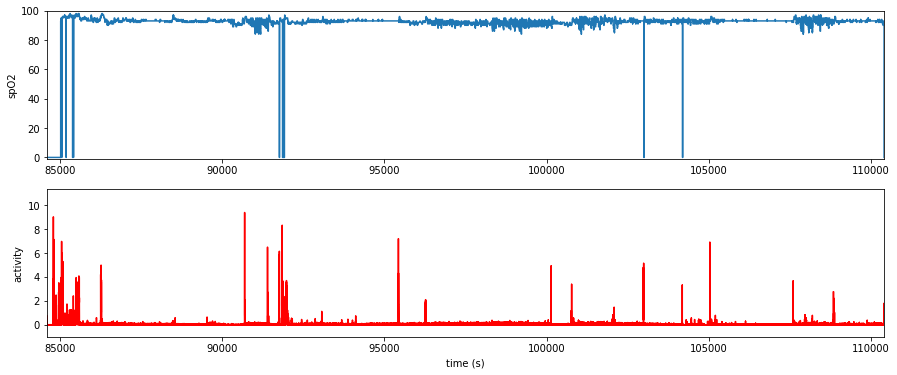

In [74]:
plt.figure()
plt.figure(figsize=(15,6))
plt.title('Plot spO2')
ax1 = plt.subplot(211)
ax2 = plt.subplot(212)
#plt.subplot(2, 1, 1)
plt.xlabel('time (s)')
ax1.set_ylabel('spO2')
ax1.axis([time_array[0],time_array[len(time_array)-1],-1,100])
ax1.step(time_array,spo2_array)
ax2.set_ylabel('activity')
ax2.axis([time_array[0],time_array[len(time_array)-1],-1,max(activity_array)+2])
ax2.step(time_activity_array,activity_array,c='r')

### Preprocessing spO2

In [6]:
#Outlier noise
str(datetime.timedelta(seconds=time_array[len(time_array)-1]))
index=df_spo2[df_spo2.spO2 == 0].index
#str(datetime.timedelta(seconds=time_array[58759]))
df_spo2=df_spo2.drop(df_spo2.index[index])  
df_outlier=pd.DataFrame()
df_outlier['time']=np.array(df_spo2['time'])
df_outlier['spO2']=np.array(df_spo2['spO2'])

Text(0.5,0,'time(s)')

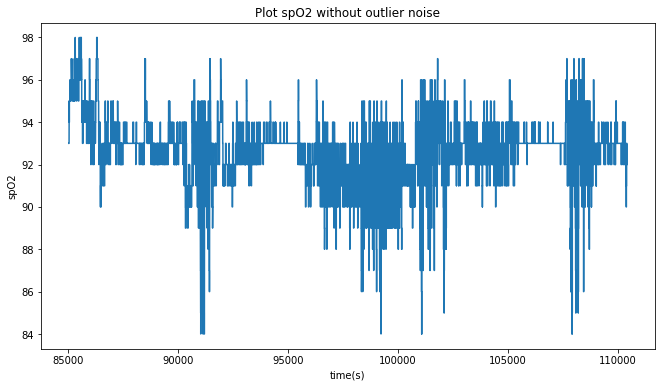

In [85]:
plt.figure(figsize=(11,6))
plt.title('Plot spO2 without outlier noise')
time_array=df_outlier['time']
spo2_array=df_outlier['spO2']
plt.step(time_array,spo2_array)
plt.ylabel('spO2')
plt.xlabel('time(s)')

### Detect activity using time series

In [9]:
serie=pd.DataFrame()
serie['activity']=activity_array
serie.index=df_activity['time']
ts = df_activity['activity'] 

media:  0.04216222113953488
std:  0.157637795129773


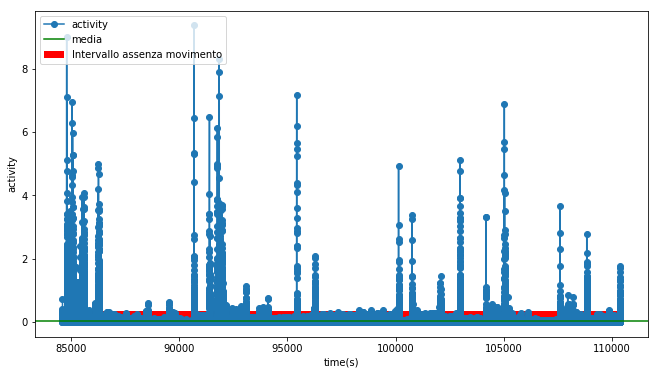

In [84]:
media=statistics.mean(activity_array)
std_dev=statistics.stdev(activity_array)
print('media: ',media)
print('std: ',std_dev)
def confidence_interval(alist, v, itv):
    return stats.t.interval(itv, df=len(alist)-1, loc=v, scale=stats.sem(alist))
CI=confidence_interval(activity_array, np.mean(activity_array), 0.1)

plt.figure(figsize=(11,6))
plt.xlabel('time(s)')
plt.ylabel('activity')
plt.plot(time_activity_array,activity_array,marker='o')
plt.axhline(y=media,color='green', linestyle='-',label='media')
plt.fill_between([time_activity_array[0],time_activity_array[len(time_activity_array)-1]],2*std_dev+media,0,facecolor='red', label='Intervallo assenza movimento')
plt.legend(loc='upper left')

Text(0,0.5,'activity')

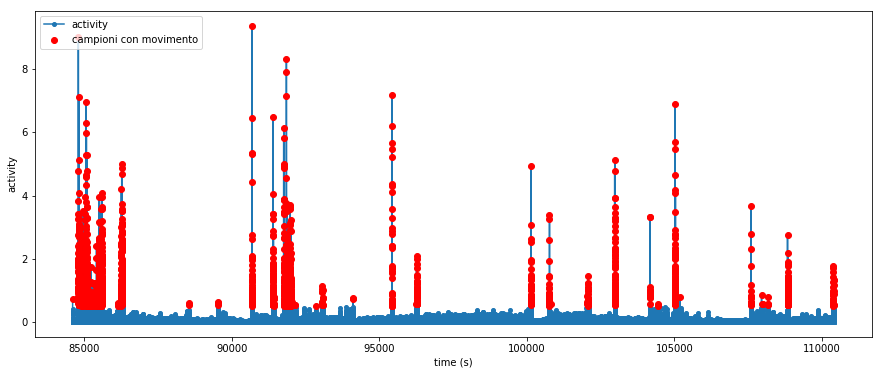

In [370]:

outlier=[]
durata=[]
valore=[]
attivita=[]
for i in range(0, len(activity_array)):
    if(activity_array[i]>3*std_dev+media):  
        outlier.append(time_activity_array[i])
        valore.append(activity_array[i])
        attivita.append(True)
    else:
        attivita.append(False)
plt.figure(figsize=(15,6))
#for i in range(0,len(outlier)):
plt.scatter(outlier,valore,marker='o', color="red",zorder=3,label='campioni con movimento')
plt.plot(time_activity_array,activity_array,marker='o',markersize=4,zorder=2, label='activity')
plt.legend(loc='upper left')
plt.xlabel('time (s)')
plt.ylabel('activity')

#### Creo un dizionario contenente ogni campione e se è presente attività

In [371]:
outlier = np.array(list(set(outlier)))
key=[i for i in time_array]
key=set(key)
values=[]
for i in (key):
    if(i in outlier):
        values.append(True)
    else:
        values.append(False)
diz=dict(zip(key, np.array(values).T))


### Algoritmo per l'estrazione dei 4 punti per la desaturazione

In [472]:
desaturations=pd.DataFrame()
spo2Translaction=[]
pstart=[]
pvalley1=[]
pvalley2=[]
pstop=[]
spo2_start=[]
spo2_stop=[]
spo2_start_s=[]
spo2_stop_s=[]
spo2_valley1=[]
spo2_valley2=[]
plowest=[]
ptraslaction=[]
tdown=[]
tup=[]
tlast=[]
durata=[]
attivita=[]
pv1=0
pv2=0
tup=[]
somma=0
'''somma=0
start_index=[]
stop_index=[]
pv1_index=[]
pv2_index=[]
stop=0'''
for i in range(0,len(spo2_array)):
    somma=somma+spo2_array[i]
xbase=1/len(spo2_array)*somma-10
CASE=0
discesa=False
minimo=100

for i in range(0,len(spo2_array)-2):
    if(CASE==0 and spo2_array[i]>spo2_array[i+1]):
        start_index=i
        minimo=100
        CASE=1
      #  minimo=spo2_array[i+1]
        discesa=True
    if(CASE==1 and spo2_array[i]==spo2_array[i+1]):
        if(discesa==True and spo2_array[i]<minimo):
            pv1=i
            minimo=spo2_array[i]
        discesa=False
    if(CASE==1 and spo2_array[i]>spo2_array[i+1]):
       # pv1=i
        pv2=i
      #  minimo=spo2_array[i+1]
        discesa=True
    if(CASE==1 and spo2_array[i]<spo2_array[i+1]):
        CASE=3
    if(CASE==3 and spo2_array[i]<spo2_array[i+1]):
        pv2=i
        #minimo=df_outlier['spO2'][i]
        CASE=4
    if(CASE==4 and spo2_array[i]==spo2_array[i+1] and spo2_array[i-1]<spo2_array[i]):
        stop_index=i
    if(CASE==4 and spo2_array[i]>spo2_array[i+1]):      
          #stop_index=i     
        t_up=df_outlier['time'][stop_index]-df_outlier['time'][pv2]
        for k in range(start_index, pv2):
            if(true==0 and diz[df_outlier['time'][k]]==True):
                true=1
                stop_index=k
                translactionIndex=k
                pv2=k
            if(true==0):
                translactionIndex=i
        #percentualeAttivita=true/d
        #if(percentualeAttivita>0):
          #  attivita.append(True)
        #else:
          #  attivita.append(False)
        translactionIndex=i
        start_time=df_outlier['time'][start_index]
        valley1_time=df_outlier['time'][pv1]
        valley2_time=df_outlier['time'][pv2]
        stop_time=df_outlier['time'][stop_index]
        spo2Stop=df_outlier['spO2'][stop_index]
        spo2Start=df_outlier['spO2'][start_index]
        d=df_outlier['time'][pv2]-start_time
        
        tdown=valley2_time-start_time
        if(d>9 and df_outlier['spO2'][pv2]<=spo2Start*0.97 ):
            true=0
            
            ptraslaction.append(df_outlier['time'][translactionIndex])
            spo2Translaction.append(spo2_array[translactionIndex])
            spo2_start_s.append(datetime.timedelta(seconds=remove_days(start_time)))
            spo2_stop_s.append(datetime.timedelta(seconds=remove_days(stop_time)))          
            pstart.append(start_time)
            pstop.append(stop_time)
            spo2_start.append(spo2Start)
            spo2_stop.append(spo2Stop)
            spo2_valley1.append(df_outlier['spO2'][pv1])
            spo2_valley2.append(df_outlier['spO2'][pv2])
            pvalley1.append(valley1_time)
            pvalley2.append(valley2_time)
            durata.append(d)
            tup.append(spo2Stop-df_outlier['spO2'][pv2])
           # start_time=remove_days(start_time)
          #  stop_time=remove_days(stop_time)
          #  valley1_time=remove_days(valley1_time)
        start_index=i
        minimo=100
        CASE=1

            
desaturations['start_time']=pstart[0:len(pstart)]
desaturations['tup']=tup  
desaturations['valley1']=pvalley1  
desaturations['valley2']=pvalley2  
desaturations['stop_time']=pstop
desaturations['translaction']=ptraslaction 
desaturations['start_time_s']=spo2_start_s[0:len(pstart)]
desaturations['stop_time_s']=spo2_stop_s
desaturations['valley1_spO2']=spo2_valley1  
desaturations['valley2_spO2']=spo2_valley2  
desaturations['start_spO2']=spo2_start[0:len(pstart)]
desaturations['stop_spO2']=spo2_stop  
desaturations['spo2Translaction']=spo2Translaction  

desaturations['durata (s)']=durata   

#desaturations['attivita']=attivita 
#desaturations

In [473]:
#a=desaturations.loc[desaturations['attivita'] == False]
a=desaturations.loc[desaturations['start_time'] > 86820]
print(len(a))
a[30:100]

188


start_time  tup  valley1  valley2  stop_time  translaction start_time_s  \
38      95468.0    2  95480.0  95486.0    95496.0       95510.0     02:31:08   
39      95774.0    2  95785.0  95799.0    95803.0       95831.0     02:36:14   
40      95903.0    2  95921.0  95932.0    95948.0       95963.0     02:38:23   
41      95985.0    3  96015.0  96022.0    96097.0       96100.0     02:39:45   
42      96319.0    3  96332.0  96345.0    96353.0       96367.0     02:45:19   
43      96367.0    3  96379.0  96385.0    96400.0       96417.0     02:46:07   
44      96417.0    2  96436.0  96437.0    96443.0       96447.0     02:46:57   
45      96447.0    1  96467.0  96468.0    96468.0       96469.0     02:47:27   
46      96539.0    5  96557.0  96568.0    96579.0       96584.0     02:48:59   
47      96584.0    3  96604.0  96607.0    96617.0       96627.0     02:49:44   
48      96627.0    6  96652.0  96655.0    96665.0       96675.0     02:50:27   
49      96675.0    1  96692.0  96694.0    96695.0       96700.0     02:51:15   
50      96719.0    6  96756.0  96758.0    96769.0       96791.0     02:51:59   
51      96791.0    3  96818.0  96828.0    96842.0       96854.0     02:53:11   
52      96854.0    3  96874.0  96878.0    96894.0       96905.0     02:54:14   
53      96905.0    3  96920.0  96930.0    96936.0       96955.0     02:55:05   
54      96987.0    4  97008.0  97012.0    97019.0       97029.0     02:56:27   
55      97029.0    3  97044.0  97045.0    97055.0       97057.0     02:57:09   
56      97057.0    5  97086.0  97088.0    97101.0       97105.0     02:57:37   
57      97105.0    2  97116.0  97139.0    97148.0       97149.0     02:58:25   
58      97149.0    5  97173.0  97185.0    97192.0       97203.0     02:59:09   
59      97203.0    3  97214.0  97225.0    97230.0       97245.0     03:00:03   
60      97245.0    3  97254.0  97274.0    97281.0       97286.0     03:00:45   
61      97327.0    4  97344.0  97353.0    97368.0       97380.0     03:02:07   
62      97458.0    3  97476.0  97486.0    97493.0       97507.0     03:04:18   
63      97507.0    3  97520.0  97529.0    97544.0       97546.0     03:05:07   
64      97546.0    3  97566.0  97581.0    97589.0       97609.0     03:05:46   
65      97779.0    6  97802.0  97803.0    97813.0       97822.0     03:09:39   
66      97822.0    3  97841.0  97847.0    97855.0       97865.0     03:10:22   
67      97865.0    2  97878.0  97895.0    97905.0       97920.0     03:11:05   
..          ...  ...      ...      ...        ...           ...          ...   
78      98502.0    5  98524.0  98531.0    98542.0       98545.0     03:21:42   
79      98545.0    4  98570.0  98571.0    98585.0       98598.0     03:22:25   
80      98598.0    3  98609.0  98620.0    98632.0       98642.0     03:23:18   
81      98642.0    8  98672.0  98678.0    98686.0       98697.0     03:24:02   
82      98697.0    5  98715.0  98720.0    98731.0       98732.0     03:24:57   
83      98732.0    4  98754.0  98760.0    98770.0       98782.0     03:25:32   
84      98782.0    3  98794.0  98797.0    98806.0       98819.0     03:26:22   
85      98819.0    6  98838.0  98839.0    98852.0       98854.0     03:26:59   
86      98854.0    8  98885.0  98890.0    98900.0       98908.0     03:27:34   
87      98908.0    3  98921.0  98929.0    98938.0       98944.0     03:28:28   
88      98944.0    5  98967.0  98971.0    98983.0       98987.0     03:29:04   
89      98987.0    9  99019.0  99021.0    99034.0       99041.0     03:29:47   
90      99041.0    5  99068.0  99074.0    99084.0       99093.0     03:30:41   
91      99093.0    4  99107.0  99117.0    99126.0       99135.0     03:31:33   
92      99135.0    8  99165.0  99169.0    99178.0       99188.0     03:32:15   
93      99188.0   11  99220.0  99225.0    99236.0       99244.0     03:33:08   
94      99244.0    5  99272.0  99275.0    99283.0       99292.0     03:34:04   
95      99292.0    6  99315.0  99316.0    99331.0       99332.0     03:34:52   
96   

### Grafico con le desaturazioni

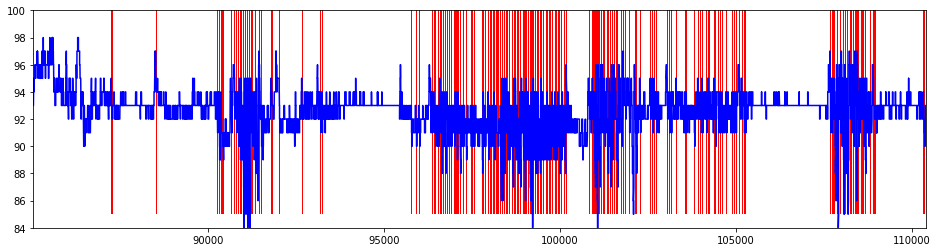

In [474]:
plt.figure(figsize=(16,4))
#plt.subplot(2, 1, 1)
plt.axis([time_array[0],time_array[len(time_array)-1],84,100])
for i in (a.index):
    plt.fill_between([a['start_time'][i],a['valley2'][i]],85,100,facecolor='red', zorder=1)
plt.plot(time_array,spo2_array,color='blue',zorder=2)


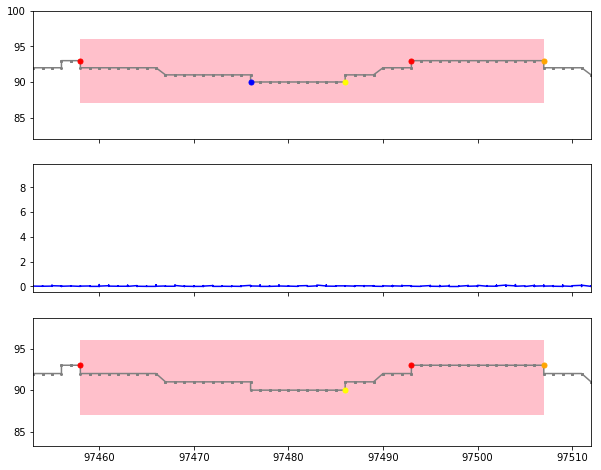

In [475]:
i=62
f, axarr = plt.subplots(3, sharex=True,figsize=(10,8))
time_array=df_outlier['time']
spo2_array=df_outlier['spO2']
axarr[0].axis([pstart[i]-5,ptraslaction[i]+5,82,100])
axarr[0].plot(df_outlier['time'],df_outlier['spO2'], marker='o',markersize=2, color="gray")
#for i in range(0,len(desaturations)):
axarr[0].plot(pstart[i],spo2_start[i],  marker='o', markersize=5, color="red")
axarr[0].plot(pvalley2[i],spo2_valley2[i],  marker='o', markersize=5, color="yellow")
axarr[0].plot(pvalley1[i],spo2_valley1[i],  marker='o', markersize=5, color="blue")
axarr[0].plot(pstop[i],spo2_stop[i],  marker='o', markersize=5, color="red")
axarr[0].plot(ptraslaction[i],spo2Translaction[i],  marker='o', markersize=5, color="orange")
axarr[0].fill_between([pstart[i],ptraslaction[i]],spo2_start[i]+3,spo2_valley2[i]-3,facecolor='pink')

#ax2.fill_between([a['start_time'][i],a['stop_time'][i]],85,100,facecolor='red', zorder=1)
axarr[1].plot(outlier[i],valore[i],marker='o',markersize=3, color="red",zorder=3)
axarr[1].plot(time_activity_array,activity_array,color='blue',zorder=2)

axarr[2].plot(df_outlier['time'],df_outlier['spO2'], marker='o',markersize=2, color="gray")
if i in a.index:
    axarr[2].plot(a['start_time'][i],a['start_spO2'][i],marker='o', markersize=5, color="red")
    axarr[2].plot(a['stop_time'][i],a['stop_spO2'][i],marker='o', markersize=5, color="red")
    axarr[2].plot(a['valley2'][i],a['valley2_spO2'][i],  marker='o', markersize=5, color="yellow")
    axarr[2].plot(a['translaction'][i],a['spo2Translaction'][i],  marker='o', markersize=5, color="orange")
    axarr[2].fill_between([a['start_time'][i],a['translaction'][i]],spo2_start[i]+3,spo2_valley2[i]-3,facecolor='pink')

#### Trasformo i tempi di inizio in hh:mm:ss in secondi in modo da confrontarli con le desaturazioni calcolate

In [484]:
inizio_s=[]
for i in range(0,len(desatPSD)):
    s=desatPSD['Inizio'][i]
    h,m,sec=s.split(':')
    x=int(h)*3600+int(m)*60+int(sec)
    if(int(h)<21):
        x=x+24*3600
    inizio_s.append(x)
desatPSD['inizio_s']=inizio_s
print(desatPSD)
#desaturations=desaturations.loc[desaturations['start_time'] > 86820]
#print(a[0:30])

      Inizio  Durata  startSpO2  stopSpO2  inizio_s
0   01:04:03   30.02         94        91     90243
1   01:05:07   40.56         94        89     90307
2   01:06:02   80.20         94        89     90362
3   01:10:34   46.75         95        91     90634
4   01:13:21   13.75         94        91     90801
5   01:14:10   23.67         94        90     90850
6   01:14:53   28.00         95        89     90893
7   01:15:39   26.29         95        89     90939
8   01:16:29   33.27         93        84     90989
9   01:17:22   33.25         95        85     91042
10  01:18:13   33.15         95        84     91093
11  01:19:15   29.33         95        84     91155
12  01:20:14   23.00         95        91     91214
13  01:20:53   18.00         94        90     91253
14  01:21:29   22.33         94        89     91289
15  01:22:12   26.00         94        89     91332
16  01:22:55   19.94         95        88     91375
17  01:24:57   27.67         93        90     91497
18  01:25:43

#### Elimino le desaturazioni trovate che non hanno un corrispondente verificato dal polisonnigrafo in modo da calcolare la precisione delle altre

In [485]:
array_index=a.index
array_start_desat=np.array(a['start_time'])
k=0
j=0
while(j<len(desatPSD)):
    if(desatPSD['inizio_s'][j]<array_start_desat[k]-30 or desatPSD['inizio_s'][j]>array_start_desat[k]+30):
        print('ELIMI:',desatPSD['Inizio'][j],',',a['start_time_s'][array_index[k]])
        a=a.drop([array_index[k]], axis='rows')
        array_start_desat=np.array(a['start_time'])    
        array_index=a.index
    else:
        k=k+1
        j=j+1
    
a[0:len(desatPSD)]

ELIMI: 01:04:03 , 0 days 00:14:05
ELIMI: 01:04:03 , 0 days 00:35:02
ELIMI: 01:13:21 , 0 days 01:12:23
ELIMI: 01:24:57 , 0 days 01:24:05
ELIMI: 01:41:24 , 0 days 01:29:59
ELIMI: 01:41:24 , 0 days 01:33:36
ELIMI: 01:53:09 , 0 days 01:51:47
ELIMI: 02:36:12 , 0 days 02:31:08
ELIMI: 02:49:43 , 0 days 02:46:57
ELIMI: 02:49:43 , 0 days 02:47:27
ELIMI: 02:49:43 , 0 days 02:48:59
ELIMI: 03:05:05 , 0 days 03:04:18
ELIMI: 03:39:13 , 0 days 03:39:59
ELIMI: 03:39:13 , 0 days 03:40:35
ELIMI: 03:39:13 , 0 days 03:41:22
ELIMI: 03:39:13 , 0 days 03:42:03
ELIMI: 03:39:13 , 0 days 03:42:53
ELIMI: 03:39:13 , 0 days 03:43:37
ELIMI: 03:39:13 , 0 days 03:44:15
ELIMI: 03:39:13 , 0 days 03:44:58
ELIMI: 03:39:13 , 0 days 03:45:43
ELIMI: 03:39:13 , 0 days 03:46:25
ELIMI: 03:39:13 , 0 days 03:47:10
ELIMI: 03:39:13 , 0 days 03:48:00
ELIMI: 03:39:13 , 0 days 03:48:40
ELIMI: 03:39:13 , 0 days 03:49:40
ELIMI: 03:39:13 , 0 days 03:50:20
ELIMI: 03:39:13 , 0 days 03:57:20
ELIMI: 03:39:13 , 0 days 04:00:20
ELIMI: 03:39:1

IndexError: index 81 is out of bounds for axis 0 with size 81

In [459]:
len(a)

176

#### Plot del'inizio valore spO2 ad inizio delle desaturazioni

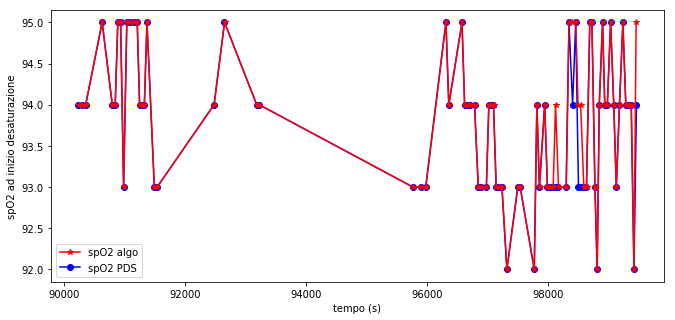

In [419]:
plt.figure(figsize=(11,5))
plt.plot(a['start_time'][0:len(desatPSD)],a['start_spO2'][0:len(desatPSD)],marker='*', color='red',zorder=2, label='spO2 algo')
plt.plot(desatPSD['inizio_s'],desatPSD['startSpO2'],marker='o',color='blue',zorder=1,label='spO2 PDS')
plt.ylabel('spO2 ad inizio desaturazione')
plt.xlabel('tempo (s)')
plt.legend(loc='best')

### Calcolo precisione algoritmo per il calcolo delle desaturazioni

##### Plot delle durate delle desat per ogni desat

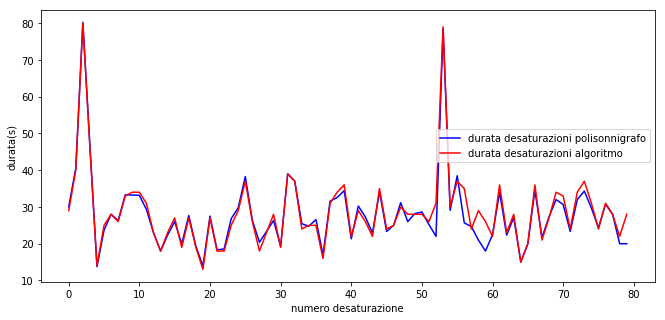

In [420]:
plt.figure(figsize=(11,5))
plt.plot([i for i in range (0,len(desatPSD))],desatPSD['Durata'],color='blue', label='durata desaturazioni polisonnigrafo')
plt.plot([i for i in range (0,len(desatPSD))],a['durata (s)'][0:len(desatPSD)],color='red', label='durata desaturazioni algoritmo')
plt.ylabel('durata(s)')
plt.xlabel('numero desaturazione')
plt.legend(loc='best')

##### Plot differenza tempo inizio delle desaturaz con quella precedente t(i+1)-t(i)

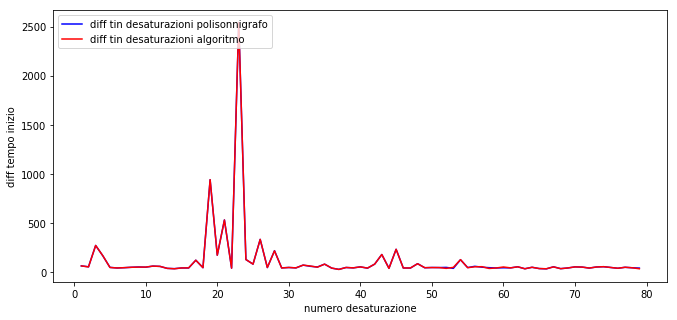

In [421]:
plt.figure(figsize=(11,5))
#plt.axis([0,3,50,60])
diff_tin_PDS=[]
diff_tin_algo=[]
for i in range(1,len(desatPSD)):
    diff_tin_PDS.append(desatPSD['inizio_s'][i]-desatPSD['inizio_s'][i-1])
    diff_tin_algo.append(a['start_time'][array_index[i]]-a['start_time'][array_index[i-1]])
plt.plot([i for i in range (1,len(desatPSD))],diff_tin_PDS,color='blue', label='diff tin desaturazioni polisonnigrafo')
plt.plot([i for i in range (1,len(desatPSD))],diff_tin_algo,color='red', label='diff tin desaturazioni algoritmo')
plt.ylabel('diff tempo inizio')
plt.xlabel('numero desaturazione')
plt.legend(loc='upper left')

##### Calcolo MSE per il tempo di inizio stimato e la durata

In [422]:
n=len(desatPSD)
#MSE tempo inizio
diff_tin=[]
for i in range(0,len(desatPSD)):
    diff_tin.append((a['start_time'][array_index[i]]-desatPSD['inizio_s'][i])**2)
MSE_tempoInizio=1/n*sum(diff_tin)
print('MSE tempo di inizio delle desaturaz: ',MSE_tempoInizio, 's')

MSE tempo di inizio delle desaturaz:  4.575 s


In [423]:
#MSE durata
diff_durata=[]
for i in range(0,len(desatPSD)):
    diff_durata.append((a['durata (s)'][array_index[i]]-desatPSD['Durata'][i])**2)
MSE_durata=1/n*sum(diff_durata)
print('MSE durata delle desaturaz: ',MSE_durata, 's')

MSE durata delle desaturaz:  5.6050499999999985 s


In [411]:
for i in range (0,len(desatPSD)):
    print(a['start_time_s'][array_index[i]],',',desatPSD['Inizio'][i])


0 days 01:04:05 , 01:04:03
0 days 01:05:09 , 01:05:07
0 days 01:06:03 , 01:06:02
0 days 01:10:35 , 01:10:34
0 days 01:13:23 , 01:13:21
0 days 01:14:11 , 01:14:10
0 days 01:14:54 , 01:14:53
0 days 01:15:40 , 01:15:39
0 days 01:16:30 , 01:16:29
0 days 01:17:22 , 01:17:22
0 days 01:18:14 , 01:18:13
0 days 01:19:16 , 01:19:15
0 days 01:20:15 , 01:20:14
0 days 01:20:54 , 01:20:53
0 days 01:21:29 , 01:21:29
0 days 01:22:12 , 01:22:12
0 days 01:22:56 , 01:22:55
0 days 01:24:58 , 01:24:57
0 days 01:25:44 , 01:25:43
0 days 01:41:26 , 01:41:24
0 days 01:44:19 , 01:44:17
0 days 01:53:10 , 01:53:09
0 days 01:53:51 , 01:53:50
0 days 02:36:14 , 02:36:12
0 days 02:38:23 , 02:38:21
0 days 02:39:45 , 02:39:43
0 days 02:45:19 , 02:45:17
0 days 02:46:07 , 02:46:04
0 days 02:49:44 , 02:49:43
0 days 02:50:27 , 02:50:27
0 days 02:51:15 , 02:51:15
0 days 02:51:59 , 02:51:59
0 days 02:53:11 , 02:53:11
0 days 02:54:14 , 02:54:11
0 days 02:55:05 , 02:55:04
0 days 02:56:27 , 02:56:26
0 days 02:57:09 , 02:57:07
0